# Application, Permit, Occupancy &mdash; NYC Build Time Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arrow
%matplotlib inline
pd.set_option("max_columns", 500)

In [2]:
data = pd.read_csv("combined_data.csv", index_col=0)

## Format conversions

Because we saved to `CSV` format all of the date variables need to be reloaded into `numpy` data forms.

First we convert dates.

In [3]:
def convert_time(date):
    if isinstance(date, float):
        return np.nan
    else:
        return np.datetime64(arrow.get(date, 'YYYY-MM-DD').datetime)

In [4]:
for col in ['Application Date', 'Issuance Date', 'Certificate Date']:
    data[col] = [convert_time(date) for date in data[col]]

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


The time deltas.

In [5]:
def convert_time_delta(delta):
    if isinstance(delta, float):
        return None
    else:
        return np.timedelta64(delta.split(" ")[0], 'D')

In [7]:
for col in ['Application Time', 'Build Time']:
    data[col] = [convert_time_delta(delta) for delta in data[col]]

In [7]:
data.head(1)

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,Community Board,Zip Code,Bldg Type,Residential,Special District 1,Special District 2,Work Type,Permit Status,Filing Status,Permit Type,Permit Sequence #,Permit Subtype,Oil Gas,Site Fill,Filing Date,Issuance Date,Expiration Date,Job Start Date,Permittee's First Name,Permittee's Last Name,Permittee's Business Name,Permittee's Phone #,Permittee's License Type,Permittee's License #,Act as Superintendent,Permittee's Other Title,HIC License,Site Safety Mgr's First Name,Site Safety Mgr's Last Name,Site Safety Mgr Business Name,Superintendent First & Last Name,Superintendent Business Name,Owner's Business Type,Non-Profit,Owner's Business Name,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,Year,Certificate Date,Build Time,Application Date,Application Time
0,BRONX,2818049.0,92,WEST TREMONT AVE,220177350.0,1.0,NB,NaN,2867.0,125.0,205,10453,2.0,YES,NaN,NaN,,ISSUED,INITIAL,NB,1.0,,,ON-SITE,2013-06-21,2013-06-21,03/20/2014,06/21/2013,JIMMY,ZERVOUDIS,GALAXY G.C.GROUP LLC,7186017000,GENERAL CONTRACTOR,0610672,,,,,,,PHILIP ANTONAKOS,GALAXY GENERAL CONTRACTIO,HPD,Y,HOUSING PRESERVATION AND DEVELOP,TIMOTHY,JOSEPH,100,GOLD STREET,NEW YORK,NY,10038.0,2.128637e+09,06/22/2013 12:00:00 AM,2013,2015-11-02,864.0,NaN,NaN


## Clean-up negatives

In a handful of cases the Build Time and Application Time parameters come back as negative. We will throw those few cases out.

In [9]:
data = data[((data['Application Time'].isnull()) | (data['Application Time'] > np.timedelta64(0, "D"))) &
            ((data['Build Time'].isnull()) | (data['Build Time'] > np.timedelta64(0, "D")))]

## Key Variables  and Opening Thoughts

The key variables of interest are:

* `Application Date` &mdash; The date that the first document that was not a pre-permit application was filed, based on data going back to April 2013.
* `Issuance Date` &mdash; The date that the first construction permit was issued.
* `Certificate Date` &mdash; The date that the first certificate of occupancy was issued.
* `Application Time` &mdash; The time between the first application and the issuance of the first building permit.
* `Build Time` &mdash; The time between the first building permit and the first certificate of occupancy.

Because the data in question is time-series data it is important to think about whether we can interpret it in terms of the overall statistics or must do so in terms of the statistics from the frame of reference of the date. We expect buildings started in 2013 to complete more often, in this dataset, than ones started in 2014, and so on down the line. The question is whether or not that effect is significant.

We will split the work between build timing and application timing.

First, the naive timing histogram.

## Permit-to-Occupancy Analysis

The sample of dates that we took consists of all borough-block-lots which recieved a construction permit in between April 25, 2013, when the open data record officially starts, and January 1, 2015, where our certificate of occupancy accessor algorithm ended its run. This means that every building has had at least 550 days in which to complete construction.

Because the open data trail ends at our starting point any further data that we might recover from running the algorithm further forward in time would be of decreasing utility and increasing incompleteness, because those buildings will have less and less time in which to complete before they no longer show up in our dataset.

Amongst the negative results we also have no way of distinguishing between cases in which a construction permit was filed for but the idea was eventually dropped, and cases where the construction permit was filed for and there has been progress of one form or another but the building still remains to be completed.

### Naive Histogram

First, the naive timing histogram.

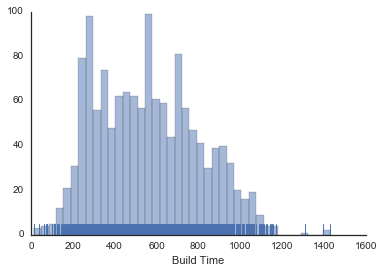

In [11]:
sns.set_style('white')
sns.distplot(data[data['Build Time'].notnull()]['Build Time'].map(lambda x: x.days),
             bins=40,
             kde=False,
             rug=True,
             hist_kws={'alpha': 0.5},
            )
sns.despine()

We see that a great part of the completes occur after 550 days, indicating that great care must be taken not interpret naive results.

The significant spikes are, on examination, batch job submissions.

Per below, about 23 percent of buildings complete before our minimum window time, 22 percent after, and 57 percent do not complete at all. Again this is strong evidence that our data is strongly time-dependent.

In [19]:
float(len(data[(data['Build Time'] > np.timedelta64("550", "D"))])) / float(len(data))

0.21729559748427674

In [50]:
float(len(data[(data['Build Time'].isnull())])) / float(len(data))

0.5657232704402516

### Time-series model

So instead we need to iteratively model a cumulative sum.

Ask the following question: given the buildings that per our dataset could still legally finish in time period X, what percentage of those buildings actually did complete? As we get further and further away this value becomes more speculative, but given that the average month contains ~80 new buildings I expect the error to remain relatively low. 

An explicit error bound will also be calculated.

The steps for this algorithm are:

1. Create a list of possible monthly timedeltas. Iterate through them.
2. Let $B=b$ — Lots built in timedelta $b$

   Let $E\geq b$ — Lots elegible to be built in timedelta $b$ (in our timeframe and not already built)
   
   For each timedelta $b$, count the number of buildings which were elegible to be built ($E$) and the number of buildings which were actually built ($B|E$).

3. We want:

$$P(B=b) = P(B \cap E) = P(B|E) \cdot P(E)$$

In [27]:
sample_months = np.arange(np.datetime64('2013-04'), np.datetime64('2016-06'), step=np.timedelta64(1,'M'))
sample_timedeltas = sample_months - np.datetime64('2013-04')

In [28]:
np.max(data['Issuance Date'])

Timestamp('2016-02-03 00:00:00')

In [84]:
# Capture buildings which were completed (for arithmatic purposes, since numpy doesn't like NaN arithmetic).
completed_buildings = data[data['Build Time'].notnull()]
# Set up the cumsum list.
# cumsum = [1]
# Set up the CDF holder.
cdf = [0]
pdf = [0]
num_observations = np.array([])

# Timedelta is a staggered list of all completion times that we could possibly have data on.
# Timedelta starts at 0 months.
# Each time we build a "window" of timedelta-to-timedelta-plus-one months.
# And squeeze what's in between.
for timedelta in sample_timedeltas:
    # Generate a list of all lots which *could* have been completed in timedelta months.
    # Two conditions:
    # 1. Given our timeframe, they could have been built in timedelta months.
#   # 2. They were not built earlier.
    elegible_lots = data[data['Issuance Date'] < np.datetime64('2016-07') - timedelta]
#     elegible_lots = elegible_lots[(elegible_lots['Build Time'].isnull()) | (elegible_lots['Build Time'] > timedelta)]
    # Capture that number.
    elegible_count = len(elegible_lots)
    num_observations = np.append(num_observations, [elegible_count])
    # Of these lots, capture which ones which *WERE* completed in one more month.
    completed_lots = elegible_lots[(elegible_lots['Build Time'].notnull()) &
                                   (elegible_lots['Build Time'] < timedelta + np.timedelta64(1, 'M')) &
                                   (elegible_lots['Build Time'] > timedelta)]
    # Capture that number.
    completed_count = len(completed_lots)
    # A = completed = # of lots completed in month X.
    # B = elegible = # of lots which could be completed in month X.
    # A / B = P(A|B) = P(completed|elegible)
    completed_given_elegible = completed_count / float(elegible_count)
    pdf.append(completed_given_elegible)
    # print(completed_count, elegible_count, completed_given_elegible)
#     cdf.append(cdf[-1] + (1 - cdf[-1]) * completed_given_elegible)
#     # 1 minus the ratio between these two values is the survival function.
#     # That is, it is the percent chance that a building which has not recieved a C of O in X months will not
#     # recieve a C of O in X+1 months either.
#     survival_rate = 1 - completed_count / float(elegible_count)
#     # Use that to calculate the effect on the survival CDF and append that to the list.
#     cumsum.append(cumsum[-1] * survival_rate)

pdf = np.array(pdf)
cdf = pdf.cumsum()

# Invert the survival cumulative to get the discrete by-month permit-to-occupancy CDF.
# cdf = 1 - np.array(cumsum)
# Subtract through to get the PDF.
# cdf = np.array(cdf)
# pdf = cdf[1:] - cdf[:-1]
# Include the largely symbolic first value into the PDF
# pdf = np.insert(pdf, 0, 0)

del completed_buildings

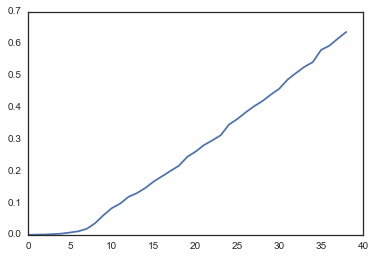

In [85]:
plt.plot(cdf)

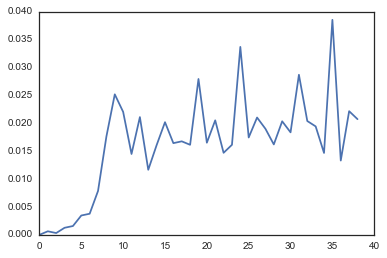

In [86]:
plt.plot(pdf)

In [87]:
num_observations

array([ 3180.,  3180.,  3180.,  3180.,  3180.,  3179.,  3178.,  3178.,
        3178.,  3178.,  3176.,  3176.,  3175.,  3173.,  3171.,  3166.,
        3164.,  3162.,  3151.,  2969.,  2876.,  2722.,  2480.,  2316.,
        2179.,  2046.,  1895.,  1729.,  1524.,  1416.,  1290.,  1128.,
         978.,   750.,   571.,   451.,   316.,   193.])

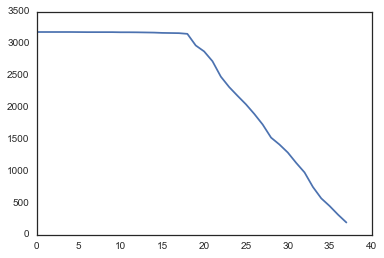

In [88]:
plt.plot(num_observations)

## Application-to-Occupancy Analysis

This data probably needs a longer time window to be significant.

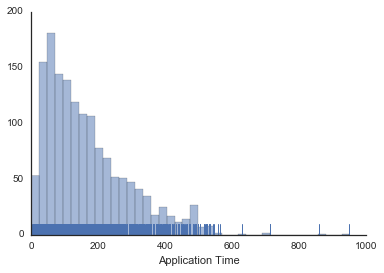

In [22]:
sns.set_style('white')
sns.distplot(data[data['Application Time'].notnull()]['Application Time'],
             bins=40,
             kde=False,
             rug=True,
             hist_kws={'alpha': 0.5},
            )
sns.despine()

In [49]:
float(len(data[data['Application Time'] > 550])) / float(len(data))

0.00220125786163522

In [27]:
len(data['Application Time'] > 550), len(data)

(3180, 3180)

In [ ]:
days = range(0, 1000)